## Aula 02 - Exercícios

In [43]:
import pandas as pd
import numpy as np

### Importar base de dados

In [44]:
# import wget
!pip install wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz


Saved under ml-20m-compact.tar (1).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [45]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,359,7481,4.0,Enemy Mine (1985)
2,422,7481,3.0,Enemy Mine (1985)
3,424,7481,3.0,Enemy Mine (1985)
4,744,7481,3.0,Enemy Mine (1985)
...,...,...,...,...
190616,131651,118606,3.5,Dots (1940)
190617,134567,118606,3.5,Dots (1940)
190618,131651,96257,1.0,Heroic Purgatory (Rengoku eroica) (1970)
190619,131651,98337,4.0,97 Percent True (2008)


### Mapeamento de ids

In [46]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

In [48]:
from math import sqrt
import numpy as np

def train_svdpp(train, n_factors, lr=0.05, reg=0.02, miter=10):

    # Calculate ratings global mean
    global_mean = train['rating'].mean()

    # Get number of unique users and items
    n_users = train['userId'].max() + 1
    n_items = train['movieId'].max() + 1

    # Initialize user and item biases arrays
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)

    # Initialize latent factor matrices for users (p) and items (q)
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))

    # Initialize latent factor matrix for implicit feedback (y)
    y = np.random.normal(0.1, 0.1, (n_items, n_factors))

    # Initialize errors list
    error = []

    # Iterate over training iterations
    for t in range(miter):
        print('iteration: ', t)
        sq_error = 0

        # Iterate over each row in the training data
        for index, row in train.iterrows():
            u = row['userId']
            i = row['movieId']
            r_ui = row['rating']

            # Calculate predicted rating using biases and latent factors
            pred = global_mean + bu[u] + bi[i] + np.dot(q[i], p[u] + y[i])

            # Calculate error between actual and predicted rating
            e_ui = r_ui - pred
            sq_error = sq_error + pow(e_ui, 2)

            # Update user and item biases
            bu[u] = bu[u] + lr * e_ui
            bi[i] = bi[i] + lr * e_ui

            # Update latent factor matrices p and q
            for f in range(n_factors):
                temp_uf = p[u, f]
                p[u][f] = p[u][f] + lr * (e_ui * (q[i][f] + y[i][f]) - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * temp_uf - reg * q[i][f])
                # Update latent factor matrix for implicit feedback (y)
                y[i, f] = y[i, f] + lr * (e_ui * q[i, f] - reg * y[i, f])

        # Append the root mean squared error to the error list
        error.append(sqrt(sq_error / len(train)))

    # Return learned parameters and error list
    return global_mean, bu, bi, p, q, y, error

# Train the SVD++ model
gl, bu, bi, p, q, y, error = train_svdpp(train, 2, miter=10)


iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9


***b)*** Plote a curva de aprendizado de seu modelo.

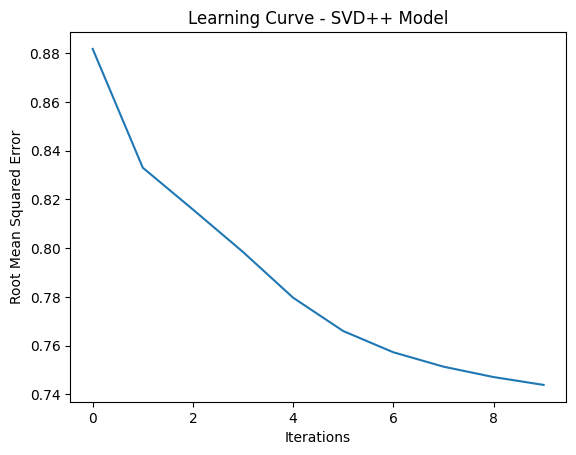

In [49]:
import matplotlib.pyplot as plt

plt.plot(error)
plt.xlabel('Iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Learning Curve - SVD++ Model')
plt.show()

***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [50]:
def predict_svdpp(user_id, item_id, global_mean, bu, bi, p, q, y):
    # Ensure user and item IDs are within bounds
    if user_id >= len(bu) or item_id >= len(bi):
        return global_mean

    # Calculate the predicted rating using biases and latent factors
    pred = global_mean + bu[user_id] + bi[item_id] + np.dot(q[item_id], p[user_id] + y[item_id])

    return pred

# Test the SVD++ model on a test set
def evaluate_svdpp(test, global_mean, bu, bi, p, q, y):
    sq_error = 0
    n_predictions = len(test)

    for index, row in test.iterrows():
        user_id = row['userId']
        item_id = row['movieId']
        actual_rating = row['rating']

        # Make a prediction using the trained model
        pred_rating = predict_svdpp(user_id, item_id, global_mean, bu, bi, p, q, y)

        # Calculate the error between actual and predicted rating
        e_ui = actual_rating - pred_rating
        sq_error += pow(e_ui, 2)

    # Calculate Root Mean Square Error (RMSE)
    rmse = sqrt(sq_error / n_predictions)
    return rmse

# Evaluate the SVD++ model on the test set
test_rmse = evaluate_svdpp(test, gl, bu, bi, p, q, y)
print("Test Root Mean Square Error (RMSE):", test_rmse)

Test Root Mean Square Error (RMSE): 0.9004731208729778
